# Notebook to compute the levele of stertypie of run around twoers 
The foirst part of then otebook is a steb by step graphical tutorial and the second part allow to process a group of mice and see how eacnh mice improve from the beginning to the end of the training

### Imports  
All functions are in behavior_analysis_functions.py

In [1]:
import os
import glob
from processing_TowerCoordinates import *
from processing_session_trajectory import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import numpy as np
#from PlottingFunctions import *




### Get mice data
Define the folder where your MOUXXX folder are, generate a list of MOUXXX folders and for each mice a list of sessions

In [2]:
# indicate where the data are
# path_to_data_folder is the path of the folder where you store your different mice.

# Windows:
# path_to_data_folder='C:'+os.sep+'Users'+os.sep+'MORVAN'+os.sep+'Documents'+os.sep+'patchouris'+os.sep+'Sample_Data'+os.sep
# Linux:
# path_to_data_folder '/home/david/Documents/Code/ForagingProject/Patchouris/patchouris/Sample_Data/'
# MacOs
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'


#path_to_data_folder='/home/david/Documents/David/Data/'
#path_to_data_folder='/LocalData/ForagingMice/JAK2Data'
#path_to_data_folder='/LocalData/ForagingMice/MaudData'
path_to_data_folder='/LocalData/ForagingMice/4TowerTaskMethodPaper/KenzaData'
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/KenzaData'


pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

# List all mice in the data folder (If you want to process all the mice in your data folder),
mice_list = [os.path.basename(path) for path in glob.glob(pattern_of_MOU_Folders)]
mice_list=sorted(mice_list)

# Print the number of mice, the list of mice, and add an empty line
print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder: {", ".join(mice_list)}\n')


#If you want to process a subset of mice uncomment the line below and comment the 2 lines above

#mice_list: list[str] = ["MOU2334"]  # For processing  a single mice. Equivalent to mice_list = ["MOU2334"] but more correct as it forces to create a list of string
#mice_list=['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']
#print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions:')
    print(session_list[mouse], '\n')








Found 18 mice in the data folder: MOUKA267, MOUKA269, MOUKA271, MOUKA274, MOUKA276, MOUKA277, MOUKA279, MOUKA280, MOUKA281, MOUKA282, MOUKA283, MOUKA284, MOUKA285, MOUKA299, MOUKA300, MOUKA303, MOUKA304, MOUKA305

Hello, I'm MOUKA267! I have foraged for 19 sessions:
['MOUKA267_20230531-1519', 'MOUKA267_20230601-0939', 'MOUKA267_20230601-1521', 'MOUKA267_20230602-0912', 'MOUKA267_20230602-1504', 'MOUKA267_20230605-0938', 'MOUKA267_20230605-1620', 'MOUKA267_20230606-1103', 'MOUKA267_20230606-1638', 'MOUKA267_20230607-0939', 'MOUKA267_20230607-1450', 'MOUKA267_20230608-0957', 'MOUKA267_20230608-1545', 'MOUKA267_20230609-1042', 'MOUKA267_20230609-1613', 'MOUKA267_20230612-0948', 'MOUKA267_20230612-1512', 'MOUKA267_20230613-0916', 'MOUKA267_20230613-1457'] 

Hello, I'm MOUKA269! I have foraged for 13 sessions:
['MOUKA269_20230607-1316', 'MOUKA269_20230608-1022', 'MOUKA269_20230608-1609', 'MOUKA269_20230609-1105', 'MOUKA269_20230609-1638', 'MOUKA269_20230612-1025', 'MOUKA269_20230612-1535', 

In [3]:
def towers_coordinates_as_dictionnary(towers_coordinates_cm):

    # Define new dictionary with explicit corner names
    towers_coordinates_as_dict = {}

    # Corner names in order
    corner_names = ['NW', 'NE', 'SE', 'SW']

    # Map tower coordinates to corner names
    for tower, coordinates in towers_coordinates_cm.items():
        towers_coordinates_as_dict[tower] = {corner_names[i]: coord for i, coord in enumerate(coordinates)}

    return towers_coordinates_as_dict

def get_tower_and_corner(run_around_tower):
    # Get the label of the tower and corner  around wich a run around tower is happening based on the  second and third elements saved in run_epochs['run_around_tower']
    tower_name = run_around_tower[1][0]  # First element, 'NE', gives the tower
    start_face = run_around_tower[1][1]  # 'W' for west, gives the starting face
    end_face = run_around_tower[2][1]    # 'S' for south, gives the ending face
    
    # Determine the corner based on the start and end faces
    if start_face == 'W' and end_face == 'S':
        corner = 'SW'
    elif start_face == 'S' and end_face == 'E':
        corner = 'SE'
    elif start_face == 'E' and end_face == 'N':
        corner = 'NE'
    elif start_face == 'N' and end_face == 'W':
        corner = 'NW'
    elif start_face == 'W' and end_face == 'N':
        corner = 'NW'
    elif start_face == 'N' and end_face == 'E':
        corner = 'NE'
    elif start_face == 'E' and end_face == 'S':
        corner = 'SE'
    elif start_face == 'S' and end_face == 'W':
        corner = 'SW'
    else:
        corner = None  # Handle unexpected cases
    
    return tower_name, corner

In [4]:
def plot_trajectories(trajectories,marker='o'):
    """
    Plot all trajectories on the same plot.
    
    Parameters:
        trajectories (list): A list of 2D numpy arrays of shape (2, X) representing the trajectories.
    """
    plt.figure(figsize=(8, 6))
    
    # Plot each trajectory
    for trajectory in trajectories:
        plt.plot(trajectory[0, :], trajectory[1, :], marker=marker, linestyle='-', label='Trajectory')
        plt.scatter(trajectory[0, 0], trajectory[1, 0], color='green', marker='o', edgecolor='green', label='Start Point',s=40)
        plt.scatter(trajectory[0, -1], trajectory[1, -1], color='red', marker='o', edgecolor='red', label='End Point',s=40) 
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('All Trajectories')
    plt.grid(True)
    
    # Show the plot
    plt.show()

### Get the pickle of all the sessions of a SINGLE mouse to quantifiy correlation between run around corners


In [5]:
mice_to_process = [mice_list[0]]
# Initialize the dictionary with empty lists for each mouse
mouse_trajectories = {mouse: [] for mouse in mice_to_process}

for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        

        
        print(f'Getting the run trajectory of session {session_to_process}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_process}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            #print(session_data['average_speed'])

        # for the first session to be analysed get the tower coordinates and then generate a dictionnary of the tower corners coordinates
        if sessionindex==0:
           towers_coordinates_cm=session_data['towers_coordinates_cm']
           towers_coordinates_as_dict=towers_coordinates_as_dictionnary(towers_coordinates_cm)
            
            
        
        
        runs_around_tower=session_data['all_epochs']['run_around_tower']
        positions=np.array(session_data['positions'])
        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch']==1:
                run_trajectory=positions[:,run_around_tower[0][0]:run_around_tower[0][1]]
                mouse_trajectories[mouse].append(run_trajectory)  # not sure this is is used



        
        # Run the processing if file doesn't exist or overwrite is True
        

Processing mouse MOUKA267. There is/are 19 sessions to process:
['MOUKA267_20230531-1519', 'MOUKA267_20230601-0939', 'MOUKA267_20230601-1521', 'MOUKA267_20230602-0912', 'MOUKA267_20230602-1504', 'MOUKA267_20230605-0938', 'MOUKA267_20230605-1620', 'MOUKA267_20230606-1103', 'MOUKA267_20230606-1638', 'MOUKA267_20230607-0939', 'MOUKA267_20230607-1450', 'MOUKA267_20230608-0957', 'MOUKA267_20230608-1545', 'MOUKA267_20230609-1042', 'MOUKA267_20230609-1613', 'MOUKA267_20230612-0948', 'MOUKA267_20230612-1512', 'MOUKA267_20230613-0916', 'MOUKA267_20230613-1457'] 

Getting the run trajectory of session MOUKA267_20230531-1519
Getting the run trajectory of session MOUKA267_20230601-0939
Getting the run trajectory of session MOUKA267_20230601-1521
Getting the run trajectory of session MOUKA267_20230602-0912
Getting the run trajectory of session MOUKA267_20230602-1504
Getting the run trajectory of session MOUKA267_20230605-0938
Getting the run trajectory of session MOUKA267_20230605-1620
Getting the 

In [6]:
# Initialize corner_aligned_trajectories as an empty dictionary for each mouse
corner_aligned_trajectories = {}

# Ensure the mouse has a dictionary of corners ('NW', 'NE', 'SE', 'SW')
corner_aligned_trajectories[mouse] = {'NW': [], 'NE': [], 'SE': [], 'SW': []}

# Loop through runs around the tower
for run_around_tower in runs_around_tower:
    if run_around_tower[3]['num_trapezeswitch']>1:
        print('not a quarter turns, skipping')
        continue

    
    # Get the tower and corner names
    tower_name, corner = get_tower_and_corner(run_around_tower)
    
    # Safely access tower and corner coordinates from the dictionary
    if tower_name in towers_coordinates_as_dict and corner in towers_coordinates_as_dict[tower_name]:
        this_corner_coordinates = towers_coordinates_as_dict[tower_name][corner]
    else:
        print(f"Invalid tower or corner: {tower_name}, {corner}")
        print(run_around_tower)
        continue  # Skip this run if there's an issue
    
    # Extract the trajectory slice based on the start and end time indices
    start_idx, end_idx = run_around_tower[0]  # Assuming it's a list like [8576, 8604]
    this_trajectory = positions[:, start_idx:end_idx]
    
    # Get the corner's reference coordinates (X and Y)
    newXreference = this_corner_coordinates[0]
    newYreference = this_corner_coordinates[1]
    
    # Shift the trajectory to reference the new corner coordinates
    this_trajectory[0, :] -= newXreference  # Shift X coordinates
    this_trajectory[1, :] -= newYreference  # Shift Y coordinates
    
    # Append the transformed trajectory to the appropriate corner in corner_aligned_trajectories
    
    corner_aligned_trajectories[mouse][corner].append(this_trajectory)   # this is just an inermediate result for plotting purpose
    

not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping
not a quarter turns, skipping


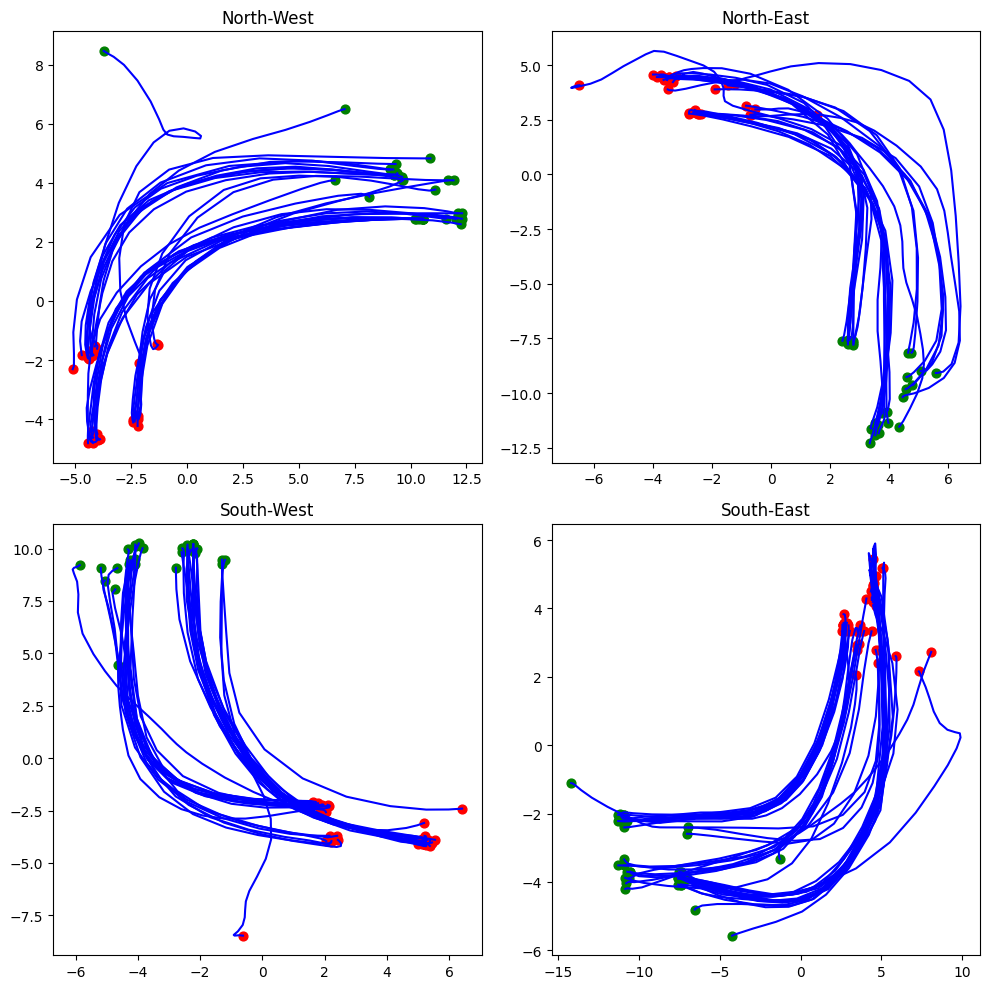

In [7]:


# Initialize a figure for the 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Titles for the subplots, corresponding to the corners
corners = ['NW', 'NE', 'SW', 'SE']
titles = {'NW': 'North-West', 'NE': 'North-East', 'SW': 'South-West', 'SE': 'South-East'}

# Define which subplot corresponds to each corner (row, col)
corner_to_subplot = {
    'NW': (0, 0),
    'NE': (0, 1),
    'SW': (1, 0),
    'SE': (1, 1)
}

# Plot each set of fixed trajectories, one per corner
for corner in corners:
    ax = axs[corner_to_subplot[corner]]
    
    # Retrieve all trajectories for the current corner
    trajectories = corner_aligned_trajectories[mouse][corner]
    
    # Plot each trajectory on the corresponding subplot
    for trajectory in trajectories:
        ax.plot(trajectory[0, :], trajectory[1, :], color='blue')  # Plot the X and Y coordinates
        ax.scatter(trajectory[0, 0], trajectory[1, 0], color='green', marker='o', edgecolor='green', label='Start Point',s=40)
        ax.scatter(trajectory[0, -1], trajectory[1, -1], color='red', marker='o', edgecolor='red', label='End Point',s=40)    
    
    # Set the title and axis limits
    ax.set_title(titles[corner])
    #ax.set_xlim(-20, 20)  # Adjust these limits according to your data
    #ax.set_ylim(-20, 20)  # Adjust these limits according to your data

# Remove superfluous spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
assert False, "Stopping execution here." 

AssertionError: Stopping execution here.

In [8]:
# This cell re-align the trajectory relative to the corner of the tower and then rotate them according to the corner position such as they can all be superposed

def rotate_SWtrajectory_90_ccw(trajectory):
    rotation_matrix = np.array([[0, -1], [1, 0]])
    return rotation_matrix @ trajectory

# Function definitions for rotation (same as before)
def rotate_NWtrajectory_180_ccw(trajectory):
    return -trajectory

def rotate_NEtrajectory_270_ccw(trajectory):
    rotation_matrix = np.array([[0, 1], [-1, 0]])
    return rotation_matrix @ trajectory

realigned_trajectories = []


mice_to_process = [mice_list[0]]
# Initialize the dictionary with empty lists for each mouse
mouse_alltrajectories = {mouse: [] for mouse in mice_to_process}
mouse_alltrajectories_persession = {mouse: {} for mouse in mice_to_process}



trajectories_per_session_realigned_rotated = {mouse: {} for mouse in mice_to_process}

# Initialize trajectories_per_corner_realigned_rotated as an empty dictionary
trajectories_per_corner_realigned_rotated = {}

# Ensure the mouse has a dictionary of corners ('NW', 'NE', 'SE', 'SW')
trajectories_per_corner_realigned_rotated[mouse] = {'NW': [], 'NE': [], 'SE': [], 'SW': []}




for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {sessionindex}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_process}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            print(session_data['average_speed'])


        # Initialize an entry for the session in the dictionary
        mouse_alltrajectories_persession[mouse][sessionindex] = []
        trajectories_per_session_realigned_rotated[mouse][sessionindex] = []

        runs_around_tower=session_data['all_epochs']['run_around_tower']
        positions=np.array(session_data['positions'])
        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch']==1: # we only take true quarter turns
                run_trajectory=positions[:,run_around_tower[0][0]:run_around_tower[0][1]]
                mouse_alltrajectories[mouse].append(run_trajectory)
                mouse_alltrajectories_persession[mouse][sessionindex].append(run_trajectory)

                # Get the tower and corner names
                tower_name, corner = get_tower_and_corner(run_around_tower)
                
                # Safely access tower and corner coordinates from the dictionary
                if tower_name in towers_coordinates_as_dict and corner in towers_coordinates_as_dict[tower_name]:
                    this_corner_coordinates = towers_coordinates_as_dict[tower_name][corner]
                else:
                    print(f"Invalid tower or corner: {tower_name}, {corner}")
                    continue  # Skip this run if there's an issue
                
                # Extract the trajectory slice based on the start and end time indices
                start_idx, end_idx = run_around_tower[0]  # Assuming it's a list like [8576, 8604]
                this_trajectory = positions[:, start_idx:end_idx]
                
                # Get the corner's reference coordinates (X and Y)
                newXreference = this_corner_coordinates[0]
                newYreference = this_corner_coordinates[1]
                
                # Shift the trajectory to reference the new corner coordinates
                this_trajectory[0, :] -= newXreference  # Shift X coordinates
                this_trajectory[1, :] -= newYreference  # Shift Y coordinates

                #Depending on which corner we are in, we rotate the trajectory accordingly

                if corner == 'SW':
                    this_trajectory = rotate_SWtrajectory_90_ccw(this_trajectory)
                elif corner == 'NW':
                    this_trajectory = rotate_NWtrajectory_180_ccw(this_trajectory)
                elif corner == 'NE':
                    this_trajectory = rotate_NEtrajectory_270_ccw(this_trajectory)
                
                # Append the transformed trajectory to the appropriate corner in corner_aligned_trajectories
                
                
                trajectories_per_session_realigned_rotated[mouse][sessionindex].append(this_trajectory)
                trajectories_per_corner_realigned_rotated[mouse][corner].append(this_trajectory) #this is use more plotting later
    







Processing mouse MOUKA267. There is/are 19 sessions to process:
['MOUKA267_20230531-1519', 'MOUKA267_20230601-0939', 'MOUKA267_20230601-1521', 'MOUKA267_20230602-0912', 'MOUKA267_20230602-1504', 'MOUKA267_20230605-0938', 'MOUKA267_20230605-1620', 'MOUKA267_20230606-1103', 'MOUKA267_20230606-1638', 'MOUKA267_20230607-0939', 'MOUKA267_20230607-1450', 'MOUKA267_20230608-0957', 'MOUKA267_20230608-1545', 'MOUKA267_20230609-1042', 'MOUKA267_20230609-1613', 'MOUKA267_20230612-0948', 'MOUKA267_20230612-1512', 'MOUKA267_20230613-0916', 'MOUKA267_20230613-1457'] 

Getting the run trajectory of session 0
8.413884768671355
Getting the run trajectory of session 1
7.752240003413303
Getting the run trajectory of session 2
9.378091470036454
Getting the run trajectory of session 3
12.217663681389544
Getting the run trajectory of session 4
13.403783396948423
Getting the run trajectory of session 5
13.179369410230661
Getting the run trajectory of session 6
14.03475928625
Invalid tower or corner: NW, None

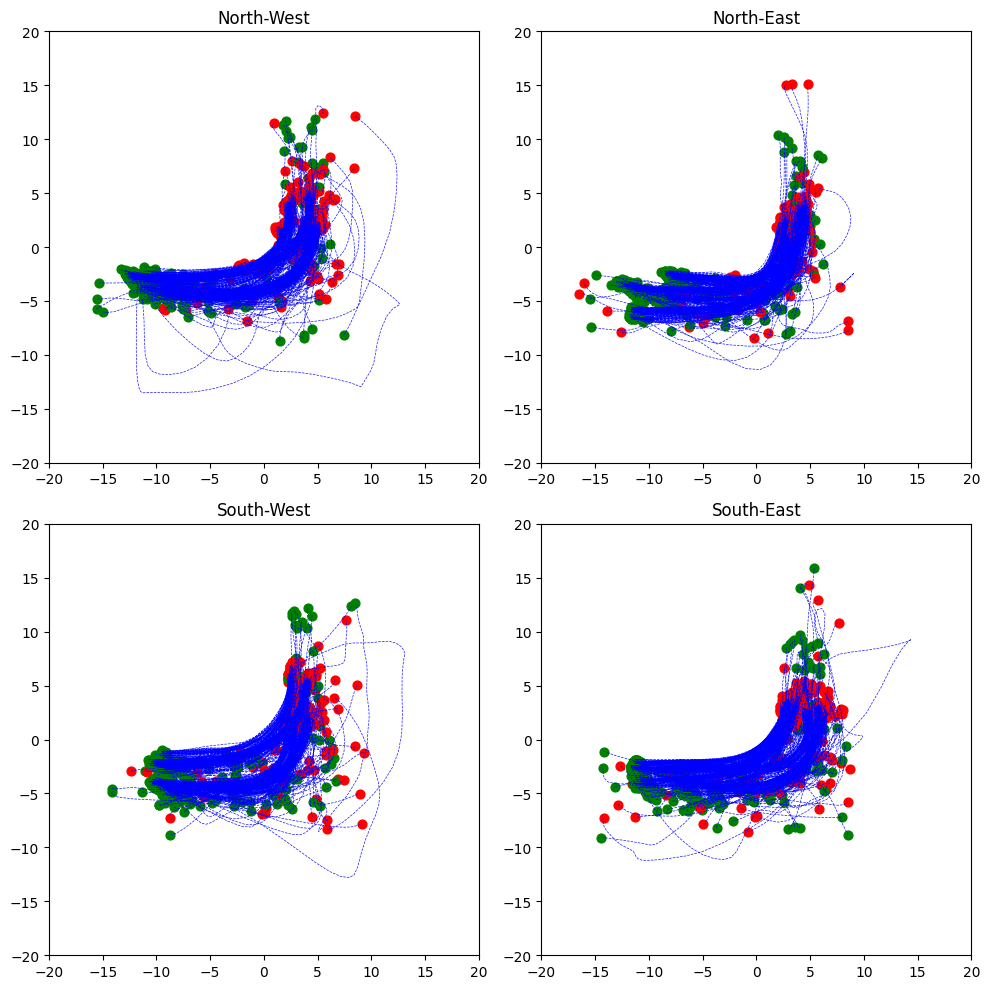

In [9]:


# Initialize a figure for the 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Titles for the subplots, corresponding to the corners
corners = ['NW', 'NE', 'SW', 'SE']
titles = {'NW': 'North-West', 'NE': 'North-East', 'SW': 'South-West', 'SE': 'South-East'}

# Define which subplot corresponds to each corner (row, col)
corner_to_subplot = {
    'NW': (0, 0),
    'NE': (0, 1),
    'SW': (1, 0),
    'SE': (1, 1)
}

# Plot each set of fixed trajectories, one per corner
for corner in corners:
    ax = axs[corner_to_subplot[corner]]
    
    # Retrieve all trajectories for the current corner
    trajectories = trajectories_per_corner_realigned_rotated[mouse][corner]
    
    # Plot each trajectory on the corresponding subplot
    for trajectory in trajectories:
        
        ax.scatter(trajectory[0, 0], trajectory[1, 0], color='green', marker='o', edgecolor='green', label='Start Point',s=40)
        ax.scatter(trajectory[0, -1], trajectory[1, -1], color='red', marker='o', edgecolor='red', label='End Point',s=40)    
        ax.plot(trajectory[0, :], trajectory[1, :], color='blue', linewidth=0.5,linestyle='dashed', alpha=0.9)  # Plot the X and Y coordinates
    
    # Set the title and axis limits
    ax.set_title(titles[corner])
    ax.set_xlim(-20, 20)  # Adjust these limits according to your data
    ax.set_ylim(-20, 20)  # Adjust these limits according to your data

# Remove superfluous spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### NOw split CW and CCW For single mouse

In [10]:
# This cell re-aligns the trajectory relative to the corner of the tower and rotates them based on the corner position and direction (CW or CCW).

def rotate_SWtrajectory_90_ccw(trajectory):
    rotation_matrix = np.array([[0, -1], [1, 0]])
    return rotation_matrix @ trajectory

def rotate_NWtrajectory_180_ccw(trajectory):
    return -trajectory

def rotate_NEtrajectory_270_ccw(trajectory):
    rotation_matrix = np.array([[0, 1], [-1, 0]])
    return rotation_matrix @ trajectory

realigned_trajectories = []

mice_to_process = [mice_list[0]]

# Initialize the dictionary with empty lists for each mouse
mouse_alltrajectories = {mouse: [] for mouse in mice_to_process}
mouse_alltrajectories_persession = {mouse: {} for mouse in mice_to_process}


trajectories_per_session_realigned_rotated = {mouse: {} for mouse in mice_to_process}

# Initialize trajectories_per_corner_realigned_rotated as an empty dictionary
# Add another level for direction ('CW' or 'CCW')
trajectories_per_corner_realigned_rotated = {}
for mouse in mice_to_process:
    trajectories_per_corner_realigned_rotated[mouse] = {
        'NW': {'CW': [], 'CCW': []},
        'NE': {'CW': [], 'CCW': []},
        'SE': {'CW': [], 'CCW': []},
        'SW': {'CW': [], 'CCW': []}
    }

for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex, session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {sessionindex}')
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_process}, skipping .....')
            continue
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            print(session_data['average_speed'])

        # Initialize an entry for the session in the dictionary
        mouse_alltrajectories_persession[mouse][sessionindex] = []
        trajectories_per_session_realigned_rotated[mouse][sessionindex] = []

        runs_around_tower = session_data['all_epochs']['run_around_tower']
        positions = np.array(session_data['positions'])

        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch'] == 1:  # Only take true quarter turns
                run_trajectory = positions[:, run_around_tower[0][0]:run_around_tower[0][1]]
                mouse_alltrajectories[mouse].append(run_trajectory)
                mouse_alltrajectories_persession[mouse][sessionindex].append(run_trajectory)

                # Get the tower and corner names
                tower_name, corner = get_tower_and_corner(run_around_tower)
                
                # Safely access tower and corner coordinates from the dictionary
                if tower_name in towers_coordinates_as_dict and corner in towers_coordinates_as_dict[tower_name]:
                    this_corner_coordinates = towers_coordinates_as_dict[tower_name][corner]
                else:
                    print(f"Invalid tower or corner: {tower_name}, {corner}")
                    continue
                
                # Extract the trajectory slice based on the start and end time indices
                start_idx, end_idx = run_around_tower[0]  # Assuming it's a list like [8576, 8604]
                this_trajectory = positions[:, start_idx:end_idx]
                
                # Get the corner's reference coordinates (X and Y)
                newXreference = this_corner_coordinates[0]
                newYreference = this_corner_coordinates[1]
                
                # Shift the trajectory to reference the new corner coordinates
                this_trajectory[0, :] -= newXreference  # Shift X coordinates
                this_trajectory[1, :] -= newYreference  # Shift Y coordinates

                # Depending on which corner we are in, rotate the trajectory accordingly
                if corner == 'SW':
                    this_trajectory = rotate_SWtrajectory_90_ccw(this_trajectory)
                elif corner == 'NW':
                    this_trajectory = rotate_NWtrajectory_180_ccw(this_trajectory)
                elif corner == 'NE':
                    this_trajectory = rotate_NEtrajectory_270_ccw(this_trajectory)

                # Get the direction (CW or CCW)
                direction = run_around_tower[3]['direction']

                # Append the transformed trajectory to the appropriate corner and direction
                
                trajectories_per_session_realigned_rotated[mouse][sessionindex].append(this_trajectory)
                trajectories_per_corner_realigned_rotated[mouse][corner][direction].append(this_trajectory)


Processing mouse MOUKA267. There is/are 19 sessions to process:
['MOUKA267_20230531-1519', 'MOUKA267_20230601-0939', 'MOUKA267_20230601-1521', 'MOUKA267_20230602-0912', 'MOUKA267_20230602-1504', 'MOUKA267_20230605-0938', 'MOUKA267_20230605-1620', 'MOUKA267_20230606-1103', 'MOUKA267_20230606-1638', 'MOUKA267_20230607-0939', 'MOUKA267_20230607-1450', 'MOUKA267_20230608-0957', 'MOUKA267_20230608-1545', 'MOUKA267_20230609-1042', 'MOUKA267_20230609-1613', 'MOUKA267_20230612-0948', 'MOUKA267_20230612-1512', 'MOUKA267_20230613-0916', 'MOUKA267_20230613-1457'] 

Getting the run trajectory of session 0
8.413884768671355
Getting the run trajectory of session 1
7.752240003413303
Getting the run trajectory of session 2
9.378091470036454
Getting the run trajectory of session 3
12.217663681389544
Getting the run trajectory of session 4
13.403783396948423
Getting the run trajectory of session 5
13.179369410230661
Getting the run trajectory of session 6
14.03475928625
Invalid tower or corner: NW, None

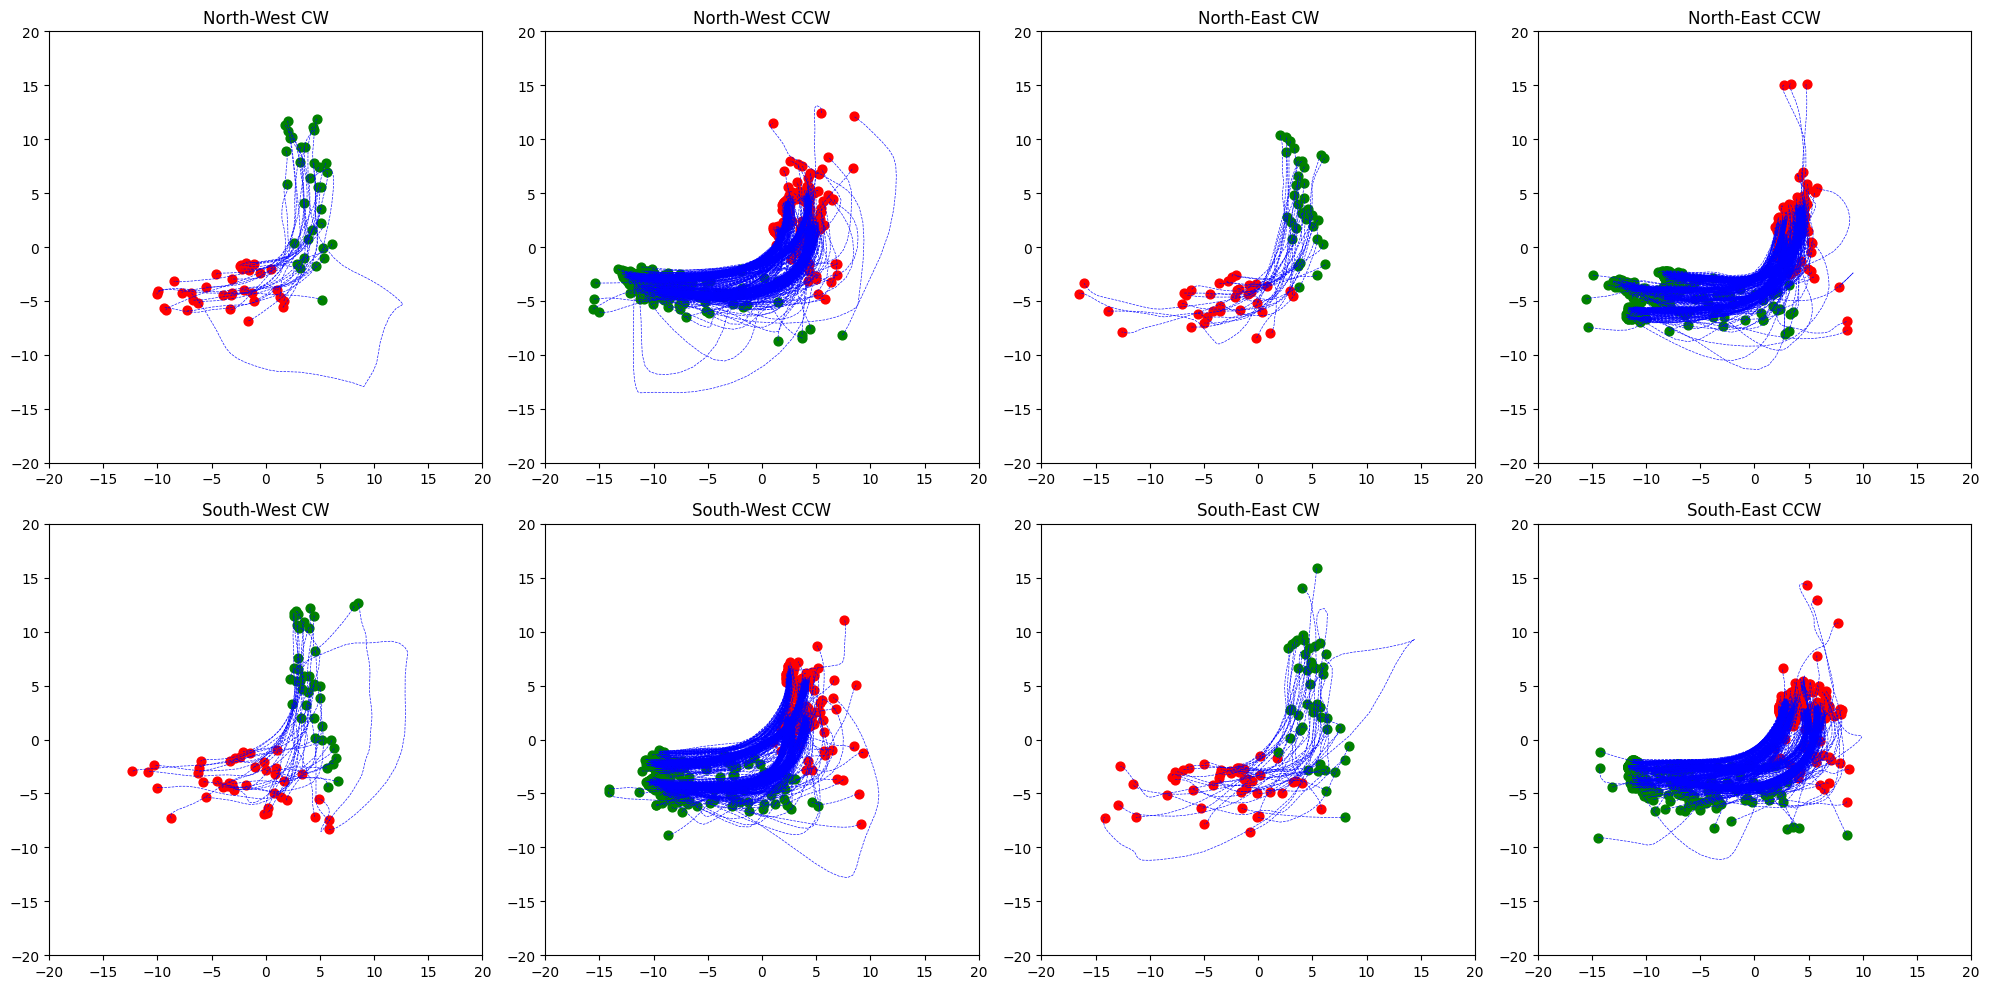

In [11]:
# Initialize a figure for the 2x4 subplot grid
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns

# Titles for the subplots, corresponding to the corners and directions
corners = ['NW', 'NE', 'SW', 'SE']
directions = ['CW', 'CCW']
titles = {
    'NW': {'CW': 'North-West CW', 'CCW': 'North-West CCW'},
    'NE': {'CW': 'North-East CW', 'CCW': 'North-East CCW'},
    'SW': {'CW': 'South-West CW', 'CCW': 'South-West CCW'},
    'SE': {'CW': 'South-East CW', 'CCW': 'South-East CCW'}
}

# Define which subplot corresponds to each corner and direction (row, col)
corner_direction_to_subplot = {
    'NW': {'CW': (0, 0), 'CCW': (0, 1)},
    'NE': {'CW': (0, 2), 'CCW': (0, 3)},
    'SW': {'CW': (1, 0), 'CCW': (1, 1)},
    'SE': {'CW': (1, 2), 'CCW': (1, 3)}
}

# Plot each set of fixed trajectories, separately for CW and CCW
for corner in corners:
    for direction in directions:
        # Determine the correct subplot based on corner and direction
        row, col = corner_direction_to_subplot[corner][direction]
        ax = axs[row, col]
        
        # Retrieve the trajectories for the current corner and direction
        trajectories = trajectories_per_corner_realigned_rotated[mouse][corner][direction]
        
        # Plot each trajectory on the corresponding subplot
        for trajectory in trajectories:
            ax.scatter(trajectory[0, 0], trajectory[1, 0], color='green', marker='o', edgecolor='green', label='Start Point', s=40)
            ax.scatter(trajectory[0, -1], trajectory[1, -1], color='red', marker='o', edgecolor='red', label='End Point', s=40)
            ax.plot(trajectory[0, :], trajectory[1, :], color='blue', linewidth=0.5, linestyle='dashed', alpha=0.9)  # Plot the X and Y coordinates
        
        # Set the title and axis limits
        ax.set_title(titles[corner][direction])
        ax.set_xlim(-20, 20)  # Adjust these limits according to your data
        ax.set_ylim(-20, 20)  # Adjust these limits according to your data

# Remove superfluous spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### NOw do the same for all the mice (realign to corner, rotate, splot CCW CW)

## This is the first key part of the code that take as input the runs_around tower and realigned them relative to the corners, translate between tower, rotate. This give us all the quarter turn realigned but CW and CCW are separated

In [13]:
# This cell re-aligns the trajectory relative to the corner of the tower and rotates them based on the corner position and direction (CW or CCW).

def rotate_SWtrajectory_90_ccw(trajectory):
    rotation_matrix = np.array([[0, -1], [1, 0]])
    return rotation_matrix @ trajectory

def rotate_NWtrajectory_180_ccw(trajectory):
    return -trajectory

def rotate_NEtrajectory_270_ccw(trajectory):
    rotation_matrix = np.array([[0, 1], [-1, 0]])
    return rotation_matrix @ trajectory

realigned_trajectories = []

mice_to_process = mice_list

# Initialize the dictionary with empty lists for each mouse
#mouse_alltrajectories = {mouse: [] for mouse in mice_to_process}
mouse_alltrajectories_persession = {mouse: {} for mouse in mice_to_process}


trajectories_per_session_realigned_rotated = {mouse: {} for mouse in mice_to_process}



for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex, session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {sessionindex}')
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_process}, skipping .....')
            continue
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            #print(session_data['average_speed'])

        # Initialize an entry for the session in the dictionary
        mouse_alltrajectories_persession[mouse][sessionindex] = []
        trajectories_per_session_realigned_rotated[mouse][sessionindex] = {'CW':[], 'CCW':[]}

        runs_around_tower = session_data['all_epochs']['run_around_tower']
        positions = np.array(session_data['positions'])

        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch'] == 1:  # Only take true quarter turns
                run_trajectory = positions[:, run_around_tower[0][0]:run_around_tower[0][1]]
                #mouse_alltrajectories[mouse].append(run_trajectory)
                mouse_alltrajectories_persession[mouse][sessionindex].append(run_trajectory)

                # Get the tower and corner names
                tower_name, corner = get_tower_and_corner(run_around_tower)
                
                # Safely access tower and corner coordinates from the dictionary
                if tower_name in towers_coordinates_as_dict and corner in towers_coordinates_as_dict[tower_name]:
                    this_corner_coordinates = towers_coordinates_as_dict[tower_name][corner]
                else:
                    print(f"Invalid tower or corner: {tower_name}, {corner}")
                    continue
                
                # Extract the trajectory slice based on the start and end time indices
                start_idx, end_idx = run_around_tower[0]  # Assuming it's a list like [8576, 8604]
                this_trajectory = positions[:, start_idx:end_idx]
                
                # Get the corner's reference coordinates (X and Y)
                newXreference = this_corner_coordinates[0]
                newYreference = this_corner_coordinates[1]
                
                # Shift the trajectory to reference the new corner coordinates
                this_trajectory[0, :] -= newXreference  # Shift X coordinates
                this_trajectory[1, :] -= newYreference  # Shift Y coordinates

                # Depending on which corner we are in, rotate the trajectory accordingly
                if corner == 'SW':
                    this_trajectory = rotate_SWtrajectory_90_ccw(this_trajectory)
                elif corner == 'NW':
                    this_trajectory = rotate_NWtrajectory_180_ccw(this_trajectory)
                elif corner == 'NE':
                    this_trajectory = rotate_NEtrajectory_270_ccw(this_trajectory)

                # Get the direction (CW or CCW)
                direction = run_around_tower[3]['direction']

                # Append the transformed trajectory to the appropriate corner and direction
                
                trajectories_per_session_realigned_rotated[mouse][sessionindex][direction].append(this_trajectory)
                #trajectories_per_corner_realigned_rotated[mouse][corner][direction].append(this_trajectory)


Processing mouse MOUKA267. There is/are 19 sessions to process:
['MOUKA267_20230531-1519', 'MOUKA267_20230601-0939', 'MOUKA267_20230601-1521', 'MOUKA267_20230602-0912', 'MOUKA267_20230602-1504', 'MOUKA267_20230605-0938', 'MOUKA267_20230605-1620', 'MOUKA267_20230606-1103', 'MOUKA267_20230606-1638', 'MOUKA267_20230607-0939', 'MOUKA267_20230607-1450', 'MOUKA267_20230608-0957', 'MOUKA267_20230608-1545', 'MOUKA267_20230609-1042', 'MOUKA267_20230609-1613', 'MOUKA267_20230612-0948', 'MOUKA267_20230612-1512', 'MOUKA267_20230613-0916', 'MOUKA267_20230613-1457'] 

Getting the run trajectory of session 0
Getting the run trajectory of session 1
Getting the run trajectory of session 2
Getting the run trajectory of session 3
Getting the run trajectory of session 4
Getting the run trajectory of session 5
Getting the run trajectory of session 6
Invalid tower or corner: NW, None
Getting the run trajectory of session 7
Getting the run trajectory of session 8
Pickle file does not exist for session MOUKA2

In [14]:
### Now we are going to nomalize the number of points such as all the trajectories in one direction have the same number of point to allow cross correlation

In [14]:
def resample_trajectory(trajectory, target_size):
    """
    Resample a single trajectory to have the target number of points.
    
    Parameters:
        trajectory (np.ndarray): A 2D numpy array of shape (2, X).
        target_size (int): The target number of points (X).
        
    Returns:
        np.ndarray: A 2D numpy array of shape (2, target_size).
    """
    # Get current number of points
    current_size = trajectory.shape[1]
    
    # Create an array of indices for the original points and the target points
    original_indices = np.linspace(0, current_size - 1, num=current_size)
    target_indices = np.linspace(0, current_size - 1, num=target_size)
    
    # Resample by interpolating the trajectory for each row (x and y coordinates)
    resampled_trajectory = np.array([np.interp(target_indices, original_indices, trajectory[i, :])
                                     for i in range(2)])
    
    return resampled_trajectory

def resample_all_trajectories(all_trajectories, target_size):
    """
    Resample all trajectories to have the same target number of points.
    
    Parameters:
        all_trajectories (list): A list of 2D numpy arrays of shape (2, X).
        target_size (int): The target number of points for each trajectory.
        
    Returns:
        list: A list of resampled 2D numpy arrays of shape (2, target_size).
    """
    resampled_trajectories = [resample_trajectory(trajectory, target_size) for trajectory in all_trajectories]
    return resampled_trajectories

def compute_pairwise_correlations(trajectories):
    """Compute pairwise correlations between trajectories."""
    num_trajectories = len(trajectories)
    print(f"Number of trajectories: {num_trajectories}")
    correlations = []
    
    for i in range(num_trajectories):
        for j in range(i + 1, num_trajectories):
            traj1 = trajectories[i]
            #print(len(traj1))
            traj2 = trajectories[j]
            #print(len(traj2))
            
            # Flatten trajectories for correlation computation
            traj1_flat = traj1.flatten()
            #print(len(traj1_flat))
            traj2_flat = traj2.flatten()
            #print(len(traj2_flat))
            
            # Compute correlation coefficient
            corr = np.corrcoef(traj1_flat, traj2_flat)[0, 1]
            correlations.append(corr)
    
    return correlations

## This is the second key part of the code that take as input trajectories_per_session_realigned_rotated and overall_correlations_per_session

In [19]:
# Initialize dictionaries to store overall correlations per session for each direction
overall_correlations_per_session = {mouse: {'CW': [], 'CCW': []} for mouse in trajectories_per_session_realigned_rotated}
numberof_turns_per_session = {mouse: {'CW': [], 'CCW': []} for mouse in trajectories_per_session_realigned_rotated}
# Directions to process
directions = ['CW', 'CCW']



for mouse in mice_to_process:
    
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')





    # Loop through each direction (CW and CCW)
    for direction in directions:
        for session_index in trajectories_per_session_realigned_rotated[mouse]:
            print(f"Processing session index: {session_index} for direction: {direction}")
            
            # Access the realigned trajectories for the current session and direction
            realigned_trajectories = trajectories_per_session_realigned_rotated[mouse][session_index][direction]
            
            if not realigned_trajectories:
                print(f"No trajectories for {direction} in session {session_index}, skipping...")
                continue
            
            
            # compute the number and length of realigned trajectories. If there is less than 5 trajctories, skip
            number_of_realigned_trajectories=len(realigned_trajectories)
            numberof_turns_per_session[mouse][direction].append([sessionindex+1,len(realigned_trajectories)])
            if number_of_realigned_trajectories<5:
                print(f"Less than 5 trajectories for {direction} in session {session_index}, skipping...")
                continue
            else:
                length_all_trajectories=[]
                for trajectory in realigned_trajectories:
                    length_all_trajectories.append(trajectory.shape[1])

            commontarget=int(np.median(length_all_trajectories))
            
            
            
            # Resample the trajectories to a fixed length (23)
            resampled_realigned_trajectories = resample_all_trajectories(realigned_trajectories, commontarget)
            
            # Compute pairwise correlations for the session
            correlations = compute_pairwise_correlations(resampled_realigned_trajectories)
            
            # Compute the overall correlation (mean of pairwise correlations)
            overall_correlation = np.mean(correlations)
            
            # Store the overall correlation for the current direction
            overall_correlations_per_session[mouse][direction].append([session_index+1,overall_correlation])
        


Processing mouse MOUKA267. There is/are 15 sessions to process:
['MOUKA305_20240419-1152', 'MOUKA305_20240424-0831', 'MOUKA305_20240424-1101', 'MOUKA305_20240424-1428', 'MOUKA305_20240425-0926', 'MOUKA305_20240425-1314', 'MOUKA305_20240425-1545', 'MOUKA305_20240426-0934', 'MOUKA305_20240426-1445', 'MOUKA305_20240429-0931', 'MOUKA305_20240429-1442', 'MOUKA305_20240430-0912', 'MOUKA305_20240430-1609', 'MOUKA305_20240501-0936', 'MOUKA305_20240501-1447'] 

Processing session index: 0 for direction: CW
Number of trajectories: 12
Processing session index: 1 for direction: CW
Number of trajectories: 26
Processing session index: 2 for direction: CW
Number of trajectories: 33
Processing session index: 3 for direction: CW
Number of trajectories: 18
Processing session index: 4 for direction: CW
Number of trajectories: 18
Processing session index: 5 for direction: CW
Number of trajectories: 9
Processing session index: 6 for direction: CW
Number of trajectories: 7
Processing session index: 7 for di

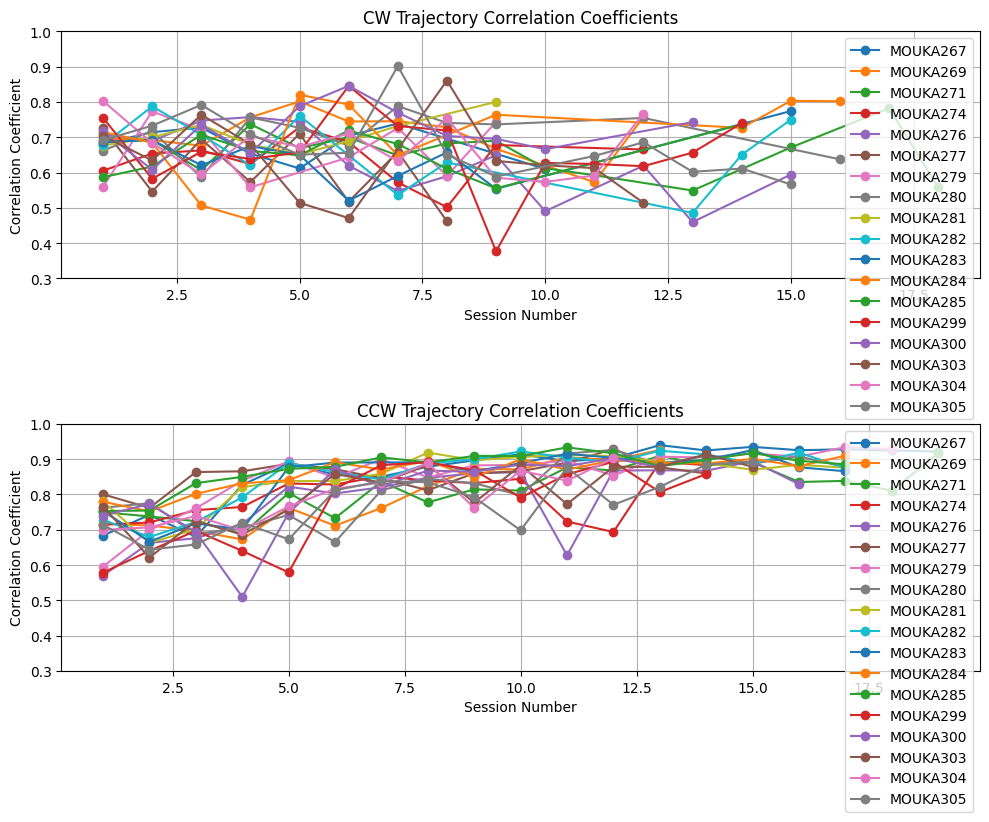

In [20]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot CW data for each mouse
for mouse, data in overall_correlations_per_session.items():
    cw_data = data['CW']
    cw_sessions = [x[0] for x in cw_data]
    cw_correlations = [x[1] for x in cw_data]
    axs[0].plot(cw_sessions, cw_correlations, marker='o', linestyle='-', label=mouse)

# Customize CW plot
axs[0].set_title('CW Trajectory Correlation Coefficients')
axs[0].set_xlabel('Session Number')
axs[0].set_ylabel('Correlation Coefficient')
axs[0].set_ylim(0.3, 1)
axs[0].grid(True)
axs[0].legend()

# Plot CCW data for each mouse
for mouse, data in overall_correlations_per_session.items():
    ccw_data = data['CCW']
    ccw_sessions = [x[0] for x in ccw_data]
    ccw_correlations = [x[1] for x in ccw_data]
    axs[1].plot(ccw_sessions, ccw_correlations, marker='o', linestyle='-', label=mouse)

# Customize CCW plot
axs[1].set_title('CCW Trajectory Correlation Coefficients')
axs[1].set_xlabel('Session Number')
axs[1].set_ylabel('Correlation Coefficient')
axs[1].set_ylim(0.3, 1)
axs[1].grid(True)
axs[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# End the rest is playing  

In [30]:
import numpy as np
from scipy.stats import entropy

# Function to discretize the space into grid cells
def discretize_trajectory(trajectory, grid_size):
    # trajectory is expected to be an array of shape (2, n_samples), representing x and y coordinates
    x_coords = trajectory[0, :]
    y_coords = trajectory[1, :]

    # Find min and max for x and y coordinates
    min_x, max_x = x_coords.min(), x_coords.max()
    min_y, max_y = y_coords.min(), y_coords.max()

    # Create grid bins
    x_bins = np.linspace(min_x, max_x, grid_size)
    y_bins = np.linspace(min_y, max_y, grid_size)

    # Digitize the trajectory into grid cells
    x_indices = np.digitize(x_coords, bins=x_bins) - 1
    y_indices = np.digitize(y_coords, bins=y_bins) - 1

    return x_indices, y_indices

# Function to calculate entropy
def calculate_trajectory_entropy(trajectory, grid_size=10):
    x_indices, y_indices = discretize_trajectory(trajectory, grid_size)

    # Stack x and y indices and count occurrences of each grid cell
    grid_cells, counts = np.unique(np.vstack((x_indices, y_indices)).T, axis=0, return_counts=True)

    # Calculate probabilities for each grid cell
    probabilities = counts / counts.sum()

    # Compute Shannon entropy
    return entropy(probabilities)



# Calculate entropy
entropy_value = calculate_trajectory_entropy(trajectory, grid_size=10)
print("Entropy of the trajectory:", entropy_value)


Entropy of the trajectory: 0.6931471805599453


In [45]:
mice_to_process = [mice_list[0]]
# Initialize the dictionary with empty lists for each mouse
mouse_entropies = {mouse: [] for mouse in mice_to_process}

for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {session_to_process}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_process}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            

        
        positions=np.array(session_data['positions'])
        entropy_value = calculate_trajectory_entropy(positions, grid_size=30)
        print("Entropy of the trajectory:", entropy_value)
        mouse_entropies[mouse].append([sessionindex,entropy_value])



        
        # Run the processing if file doesn't exist or overwrite is True
        

Processing mouse MOUKA267. There is/are 19 sessions to process:
['MOUKA267_20230531-1519', 'MOUKA267_20230601-0939', 'MOUKA267_20230601-1521', 'MOUKA267_20230602-0912', 'MOUKA267_20230602-1504', 'MOUKA267_20230605-0938', 'MOUKA267_20230605-1620', 'MOUKA267_20230606-1103', 'MOUKA267_20230606-1638', 'MOUKA267_20230607-0939', 'MOUKA267_20230607-1450', 'MOUKA267_20230608-0957', 'MOUKA267_20230608-1545', 'MOUKA267_20230609-1042', 'MOUKA267_20230609-1613', 'MOUKA267_20230612-0948', 'MOUKA267_20230612-1512', 'MOUKA267_20230613-0916', 'MOUKA267_20230613-1457'] 

Getting the run trajectory of session MOUKA267_20230531-1519
Entropy of the trajectory: 5.391311432066193
Getting the run trajectory of session MOUKA267_20230601-0939
Entropy of the trajectory: 5.685244868184335
Getting the run trajectory of session MOUKA267_20230601-1521
Entropy of the trajectory: 5.66318419195049
Getting the run trajectory of session MOUKA267_20230602-0912
Entropy of the trajectory: 5.559920405699787
Getting the run 

In [38]:
xposition=positions[0,:]
yposition=positions[1,:]

In [32]:
min_x, max_x = xposition.min(), xposition.max()
min_y, max_y = yposition.min(), yposition.max()

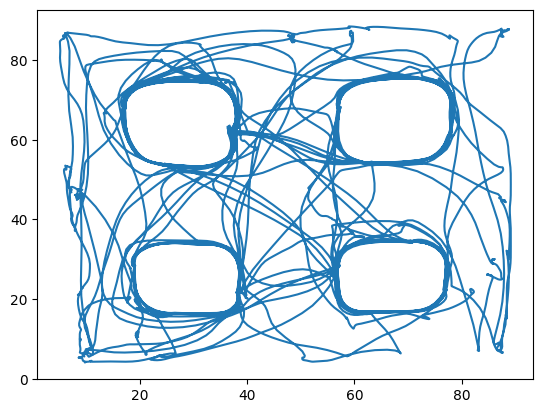

In [39]:
plt.plot(xposition,yposition)

# Playing with PCA

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_to_trajectory(trajectory, n_components=2):
    """
    Apply PCA to a single trajectory and return the first two principal components.
    
    Parameters:
        trajectory (np.ndarray): A 2D numpy array of shape (2, X).
        n_components (int): Number of principal components to keep.
        
    Returns:
        np.ndarray: A 2D numpy array of the transformed trajectory in the space of the first two PCs.
    """
    # Transpose trajectory to have shape (X, 2) for PCA input
    trajectory_t = trajectory.T
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    transformed_trajectory = pca.fit_transform(trajectory_t)
    
    return transformed_trajectory

def apply_pca_to_all_trajectories(trajectories, n_components=2):
    """
    Apply PCA to all trajectories and extract the first two principal components.
    
    Parameters:
        trajectories (list): A list of 2D numpy arrays of shape (2, X).
        n_components (int): Number of principal components to keep.
        
    Returns:
        list: A list of transformed trajectories in the space of the first two PCs.
    """
    transformed_trajectories = [apply_pca_to_trajectory(traj, n_components) for traj in trajectories]
    return transformed_trajectories


In [ ]:
# Apply PCA to the resampled trajectories
pca_transformed_trajectories = apply_pca_to_all_trajectories(resampled_trajectories)

# Print the first two principal components of each trajectory
for idx, traj in enumerate(pca_transformed_trajectories):
    print(f"Trajectory {idx + 1} (first two PCs):\n{traj}\n")


Trajectory 1 (first two PCs):
[[-7.10350967 -1.35893374]
 [-6.97518037 -1.1101479 ]
 [-6.71691929 -0.77492688]
 [-6.35163586 -0.37151231]
 [-5.94443658 -0.02350473]
 [-5.46990467  0.20404212]
 [-4.87818112  0.33603757]
 [-4.28347187  0.45216335]
 [-3.73004398  0.57956695]
 [-3.09623533  0.71465983]
 [-2.29967975  0.82099186]
 [-1.36818285  0.79319402]
 [-0.25347784  0.6368385 ]
 [ 1.08362544  0.51042972]
 [ 2.66906364  0.4302572 ]
 [ 4.30908336  0.25850649]
 [ 5.6629758  -0.0203514 ]
 [ 6.58584846 -0.23707106]
 [ 7.13921941 -0.34638237]
 [ 7.47632568 -0.40276758]
 [ 7.74039024 -0.41599689]
 [ 7.90026499 -0.36683591]
 [ 7.90406216 -0.30825684]]

Trajectory 2 (first two PCs):
[[ 6.61569663 -1.55152724]
 [ 6.54456965 -1.45560138]
 [ 6.50929009 -1.25547213]
 [ 6.3821611  -0.98156366]
 [ 6.04734071 -0.66040218]
 [ 5.53344521 -0.29855447]
 [ 4.94946352  0.09512926]
 [ 4.30496797  0.50082024]
 [ 3.58699803  0.88351468]
 [ 2.8036971   1.24768561]
 [ 1.91330577  1.59405559]
 [ 0.86183753  1.848

In [ ]:
pca_transformed_trajectories[0]

array([[-7.10350967, -1.35893374],
       [-6.97518037, -1.1101479 ],
       [-6.71691929, -0.77492688],
       [-6.35163586, -0.37151231],
       [-5.94443658, -0.02350473],
       [-5.46990467,  0.20404212],
       [-4.87818112,  0.33603757],
       [-4.28347187,  0.45216335],
       [-3.73004398,  0.57956695],
       [-3.09623533,  0.71465983],
       [-2.29967975,  0.82099186],
       [-1.36818285,  0.79319402],
       [-0.25347784,  0.6368385 ],
       [ 1.08362544,  0.51042972],
       [ 2.66906364,  0.4302572 ],
       [ 4.30908336,  0.25850649],
       [ 5.6629758 , -0.0203514 ],
       [ 6.58584846, -0.23707106],
       [ 7.13921941, -0.34638237],
       [ 7.47632568, -0.40276758],
       [ 7.74039024, -0.41599689],
       [ 7.90026499, -0.36683591],
       [ 7.90406216, -0.30825684]])

In [ ]:
def prepare_data_for_pca(trajectories):
    """
    Flatten each trajectory and combine them into a single dataset for PCA.
    
    Parameters:
        trajectories (list): A list of 2D numpy arrays where each array has shape (2, 20).
        
    Returns:
        np.ndarray: A 2D numpy array where each row represents a flattened trajectory.
    """
    # Flatten each trajectory and stack them into a single matrix
    flattened_trajectories = [traj.flatten() for traj in trajectories]
    combined_data = np.array(flattened_trajectories)
    return combined_data

In [ ]:
combined_data=prepare_data_for_pca(resampled_trajectories)

In [ ]:
import matplotlib.cm as cm
def apply_pca(combined_data, n_components=2):
    """
    Apply PCA to the combined dataset.
    
    Parameters:
        combined_data (np.ndarray): The dataset to apply PCA to.
        n_components (int): Number of principal components to keep.
        
    Returns:
        PCA: Fitted PCA object.
        np.ndarray: The transformed data in PCA space.
    """
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(combined_data)
    return pca, pca_transformed

def transform_trajectory(pca, trajectory):
    """
    Transform a single trajectory into the PCA space.
    
    Parameters:
        pca (PCA): Fitted PCA object.
        trajectory (np.ndarray): A 2D numpy array of shape (2, 20).
        
    Returns:
        np.ndarray: The transformed trajectory in PCA space.
    """
    trajectory_flattened = trajectory.flatten().reshape(1, -1)
    transformed_trajectory = pca.transform(trajectory_flattened)
    return transformed_trajectory

def plot_pca_trajectories(pca_transformed_trajectories):
    """
    Plot PCA-transformed trajectories as points in 2D space with a gradient color from first to last trajectory.
    
    Parameters:
        pca_transformed_trajectories (np.ndarray): A 2D numpy array where each row represents a trajectory in PCA space.
    """
    plt.figure(figsize=(8, 6))
    
    # Create a color map with a gradient
    num_trajectories = pca_transformed_trajectories.shape[0]
    colors = cm.viridis(np.linspace(0, 1, num_trajectories))
    
    # Plot each trajectory as a point with its corresponding color from the gradient
    for i, traj in enumerate(pca_transformed_trajectories):
        plt.scatter(traj[0], traj[1], color=colors[i], label=f'Trajectory {i+1}')
    
    # Add labels and title
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Transformed Trajectories with Gradient Coloring')
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [ ]:
pca, pca_transformed=apply_pca(combined_data)

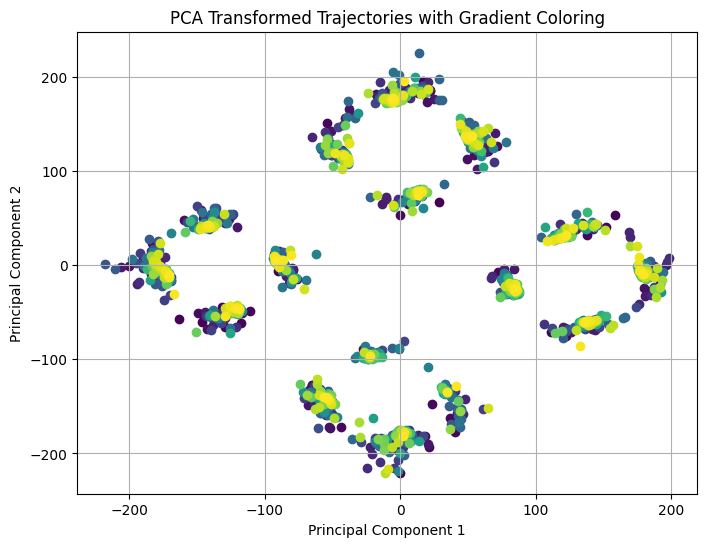

In [ ]:
# Transform each trajectory to PCA space
pca_transformed_trajectories = np.array([transform_trajectory(pca, traj).flatten() for traj in resampled_trajectories])

# Plot the PCA-transformed trajectories
plot_pca_trajectories(pca_transformed_trajectories)

In [ ]:
pca

PCA(n_components=2)

In [ ]:
# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

mice_to_process = [mice_list[0]]
for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Processing the trajectory of session {session_to_process}')
        if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
            trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
            all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
            
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not overwrite and os.path.exists(output_pickle_filepath):
            print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
            continue  # Skip processing if the file exists and overwrite is False
        
        # Run the processing if file doesn't exist or overwrite is True
        process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
        print('#########################\n')

Processing mouse MOU2329. There is/are 22 sessions to process:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Processing the trajectory of session MOU2329_20240607-1315
Total time: 885.00 s.
The total distance is: 93.80 m
The average running speed is: 10.60 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /Users/davidrobbe/Documents/Science/Data/Foragin

In [ ]:
# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

mice_to_process = [mice_list[0]]
for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Processing the trajectory of session {session_to_process}')
        if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
            trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
            all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
            
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not overwrite and os.path.exists(output_pickle_filepath):
            print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
            continue  # Skip processing if the file exists and overwrite is False
        
        # Run the processing if file doesn't exist or overwrite is True
        process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
        print('#########################\n')

Processing mouse MOU2329. There is/are 22 sessions to process:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Processing the trajectory of session MOU2329_20240607-1315
Total time: 885.00 s.
The total distance is: 93.80 m
The average running speed is: 10.60 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /Users/davidrobbe/Documents/Science/Data/Foragin

In [ ]:
# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

mice_to_process = [mice_list[0]]
for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Processing the trajectory of session {session_to_process}')
        if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
            trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
            all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
            
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not overwrite and os.path.exists(output_pickle_filepath):
            print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
            continue  # Skip processing if the file exists and overwrite is False
        
        # Run the processing if file doesn't exist or overwrite is True
        process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
        print('#########################\n')

Processing mouse MOU2329. There is/are 22 sessions to process:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Processing the trajectory of session MOU2329_20240607-1315
Total time: 885.00 s.
The total distance is: 93.80 m
The average running speed is: 10.60 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /Users/davidrobbe/Documents/Science/Data/Foragin

### Process a defined subset of sessions of a single mice in the mouse_list

In [ ]:
# same of code as above if you want to process a single session for a single mouse (obviously yu can process two or three)
mice_to_process="MOU2333"
sessions_to_process=['MOU2333_20240610-1557', 'MOU2333_20240611-1118']

# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

folder_path_mouse_to_process = os.path.join(path_to_data_folder, mice_to_process)

# Get the list of sessions


nb_sessions = len(sessions_to_process)
print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
print(sessions_to_process, '\n')

# Process each session
for sessionindex,session_to_process in enumerate(sessions_to_process):
    print(f'Processing the trajectory of session {session_to_process}')
    if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
        trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
        all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
        
    
    # Define the pickle file path
    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
    
    # Check if the pickle file already exists
    if not overwrite and os.path.exists(output_pickle_filepath):
        print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
        continue  # Skip processing if the file exists and overwrite is False
    
    # Run the processing if file doesn't exist or overwrite is True
    process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
    print('#########################\n')

Processing mouse MOU2329. There is/are 2 sessions to process:
['MOU2333_20240610-1557', 'MOU2333_20240611-1118'] 

Processing the trajectory of session MOU2333_20240610-1557
Total time: 884.96 s.
The total distance is: 74.38 m
The average running speed is: 8.40 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /LocalData/ForagingMice/JAK2Data/MOU2333/MOU2333_20240610-1557/MOU2333_20240610-1557_basic_processing_output.pickle
#########################

Processing the trajectory of session MOU2333_20240611-1118
Total time: 885.00 s.
The total distance is: 78.86 m
The average running speed is: 8.91 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /LocalData/ForagingMice/JAK2Data/MOU2333/MOU2333_20240611-1118/MOU2333_2